# DATA LOADING

In [6]:
import datetime 
import calendar 
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import scipy 
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler



filename = 'ds_for_test.pkl'

df = pd.read_pickle(filename, 'infer')


print('Data loading succeeded')

#Drop duplicates

print("Number of duplicate rows: ", df[df.duplicated()].shape)
df = df.drop_duplicates()
print("Duplicated rows dropped")

Data loading succeeded
Number of duplicate rows:  (0, 13)
Duplicated rows dropped


# CHARGER INSIGHTS

Creation of a new df in order to synthetize interesting data from the main df. We create 5 new features : *day*, *month*, *year*, *timeOfUse* and *timeOfCharge*. day (resp month, year) is the day (resp month, year) of the week the charging session occured. timeOfUse is the total time of connection of the EV to the charger, and timeOfCharge is the time that the EV is actually getting charged.

**1) Charge sessions distribution and ranking of the chargers depending on their time of use, and idle time.**

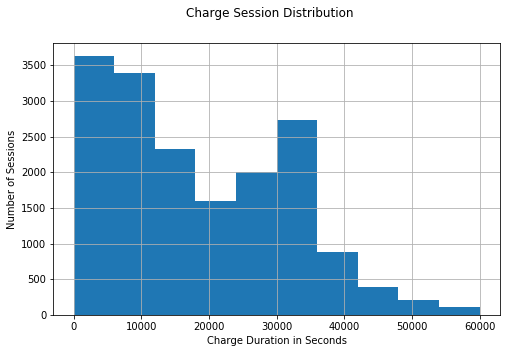



Average charge duration in hour : 5.46


In [7]:
#Definition of new variables
timeOfUseSec = (df['disconnectTime']-df['connectionTime']).to_numpy()/np.timedelta64(1, 's')
timeOfChargeSec = (df['doneChargingTime']-df['connectionTime']).to_numpy()/np.timedelta64(1, 's')

newdf = pd.DataFrame({"stationID": df.stationID, "spaceID" : df.spaceID ,"day":df.connectionTime.dt.dayofweek, "month": df.doneChargingTime.dt.month, "year": df.doneChargingTime.dt.year, "timeOfUse": timeOfUseSec, "timeOfCharge" : timeOfChargeSec,"connectionHour": df.connectionTime.dt.hour})
mean_charge_duration = newdf["timeOfUse"].mean()

#Charge session distribution 
plt.rcParams['figure.figsize'] = (8, 5)
newdf.timeOfUse.hist(range=(0,60000))
plt.xlabel('Charge Duration in Seconds')
plt.ylabel('Number of Sessions')
plt.suptitle('Charge Session Distribution')
plt.show()

print("\n\nAverage charge duration in hour : %.2f"%(mean_charge_duration/3600))

There are 17416 sessions in the dataset. This histogram only takes into account the charges that have lasted less than 60000 seconds.We can observe that the majority of the sessions have a duration in seconds between 0 and 20000 seconds i.e between 0 and 2h45min. There are a few sessions that have lasted more than 60000 but they're pretty rare. The average charge duration is approximately of 19664 seconds i.e around 5h30min.

In [8]:
stationdurationdf = newdf.groupby(['stationID']).sum().drop(columns=['day', 'month','year'])
idletimedf = pd.DataFrame({"idleTime":stationdurationdf.timeOfUse-stationdurationdf.timeOfCharge, "idleRatio":stationdurationdf.timeOfCharge/stationdurationdf.timeOfUse})

duration_per_day_hour =[0,0,0,0,0,0,0]

time_charge_month_2018 = [0,0,0,0,0,0,0,0,0,0,0,0]
time_charge_month_2019 = [0,0,0,0,0,0,0,0,0,0,0,0]

time_use_month_2018 = [0,0,0,0,0,0,0,0,0,0,0,0]
time_use_month_2019 = [0,0,0,0,0,0,0,0,0,0,0,0]

nb_unique_chargers = len(newdf.groupby('stationID').nunique())

#Print the 10 more used chargers
print("\n---------10 Most Used Chargers----------")
print(stationdurationdf.drop(columns=['timeOfCharge','connectionHour']).nlargest(10, 'timeOfUse'))

#Print the 10 less used chargers
print("---------10 Less Used Chargers----------")
print(stationdurationdf.drop(columns=['timeOfCharge','connectionHour']).nsmallest(10, 'timeOfUse'))

#Print the 10 chargers with the lowest proportion of idle time
print("---10 chargers with the lowest proportion of idle time (mean :  %.4f"%idletimedf["idleRatio"].mean(),") ---")
print(idletimedf.drop(columns='idleTime').nsmallest(10, 'idleRatio'))

#Print the 10 chargers with less idle time
print("---------10 chargers with less idle time----------")
print(idletimedf.drop(columns='idleRatio').nsmallest(10, 'idleTime'))
print("----------------------------------------")



---------10 Most Used Chargers----------
              timeOfUse
stationID              
2-39-139-28  16098815.0
2-39-79-379  14761492.0
2-39-131-30  14491459.0
2-39-89-25   12312368.0
2-39-95-27   11935823.0
2-39-79-377  11727621.0
2-39-129-17  11720223.0
2-39-79-378  11225656.0
2-39-91-437  11179124.0
2-39-79-380  11080301.0
---------10 Less Used Chargers----------
              timeOfUse
stationID              
2-39-82-385     20502.0
2-39-82-384     65644.0
2-39-83-387    568978.0
2-39-125-559   858412.0
2-39-127-561   859509.0
2-39-129-563  1110475.0
2-39-139-567  1399921.0
2-39-131-565  1433802.0
2-39-130-564  1453990.0
2-39-126-560  1464383.0
---10 chargers with the lowest proportion of idle time (mean :  0.5048 ) ---
              idleRatio
stationID              
2-39-124-558   0.327990
2-39-79-379    0.356373
2-39-95-27     0.402058
2-39-123-23    0.406636
2-39-91-437    0.411644
2-39-90-440    0.412217
2-39-89-439    0.414214
2-39-79-378    0.415554
2-39-131-565   0.427281


We see that the maximum of time of use cumulated over the period of time is approximately of 4472 hours. 

We also have that 6 out of the 10 most used chargers are also having a low proportion of idle time in their total total time of use. Their ratios are lower than the mean which is approximately equal to 0.5. It can be due to the fact that the people whom use these chargers tend to rush because they know that a lot of people are waiting to use them, so once the charging is completed they leave the charging station, but we can't make a conclusion only based on this dataset.

**2) Time of charge per day and use of the chargers over the total period of time**

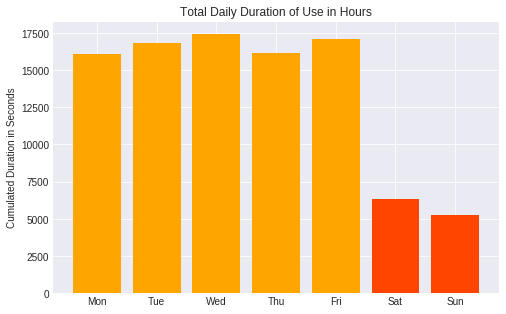

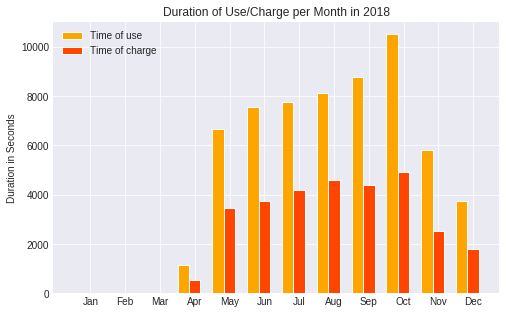

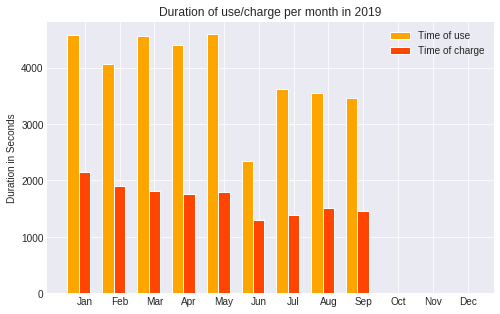

In [0]:
 #Filling of the lists
for i in range(len(newdf.index)):
      #Increment duration_per_day_sec to calculate the total duration of use per day
      duration_per_day_hour[newdf.iloc[i,2]]+=(newdf.iloc[i,5])/3600
      #Same for the month but we calculate as well the time of charge
      if newdf.iloc[i,4]==2018:
          time_use_month_2018[newdf.iloc[i,3]-1]+=(newdf.iloc[i,5])/3600
          time_charge_month_2018[newdf.iloc[i,3]-1]+=(newdf.iloc[i,6])/3600
      else : 
          time_use_month_2019[newdf.iloc[i,3]-1]+=(newdf.iloc[i,5])/3600
          time_charge_month_2019[newdf.iloc[i,3]-1]+=(newdf.iloc[i,6])/3600
 
 #Graphs

labels_day = 'Mon','Tue','Wed', 'Thu', 'Fri','Sat', 'Sun'
labels_month = 'Jan','Feb','Mar', 'Apr', 'May','Jun', 'Jul','Aug','Sep','Oct','Nov','Dec'

#Total daily duration of use in hours
plt.title('Total Daily Duration of Use in Hours')
y_pos = np.arange(len(labels_day))
plt.ylabel('Cumulated Duration in Seconds')
plt.bar(y_pos, duration_per_day_hour, color=['orange', 'orange', 'orange', 'orange', 'orange', 'orangered', 'orangered'])
plt.xticks(y_pos, labels_day)
plt.show()

#Duration of use/charge per month in 2018
plt.title('Duration of Use/Charge per Month in 2018')
barWidth = 0.33
r1 = np.arange(len(time_use_month_2018))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, time_use_month_2018, color='orange', width=barWidth, edgecolor='white', label='Time of use')
plt.bar(r2, time_charge_month_2018, color='orangered', width=barWidth, edgecolor='white', label='Time of charge')
plt.ylabel('Duration in Seconds')
plt.xticks([r + barWidth for r in range(len(time_use_month_2018))], labels_month)
 
plt.legend()
plt.show()

#Duration of use/charge per month in 2019
plt.title('Duration of use/charge per month in 2019')
barWidth = 0.33
r1 = np.arange(len(time_use_month_2018))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, time_use_month_2019, color='orange', width=barWidth, edgecolor='white', label='Time of use')
plt.bar(r2, time_charge_month_2019, color='orangered', width=barWidth, edgecolor='white', label='Time of charge')
plt.ylabel('Duration in Seconds')
plt.xticks([r + barWidth for r in range(len(time_use_month_2019))], labels_month)
 
plt.legend()
plt.show()

The cumulated time of use of the chargers over the total period of time is the highest on wednesday and the lowest on sunday.

The time of use has increased from May 2018 to October 2018, and has been decreasing since November 2018. The last two graphs also confirmed the fact that the duration of charge is on average half lower than the time of use.


**3) Analysis of sessions per hour per day and amount of idle chargers**

Estimation of the number of simultaneous sessions at the peak on day  0  : 12
Estimation of the number of simultaneous sessions at the peak on day  1  : 12
Estimation of the number of simultaneous sessions at the peak on day  2  : 13
Estimation of the number of simultaneous sessions at the peak on day  3  : 13
Estimation of the number of simultaneous sessions at the peak on day  4  : 13
Estimation of the number of simultaneous sessions at the peak on day  5  : 3
Estimation of the number of simultaneous sessions at the peak on day  6  : 2




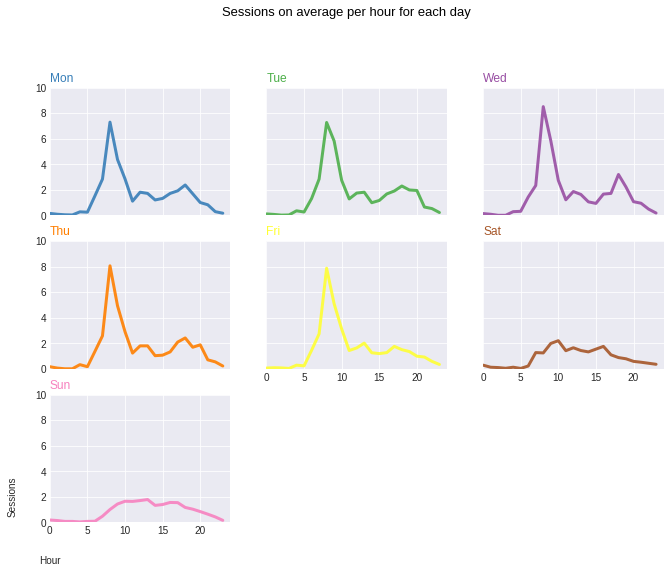

In [0]:
#Creating of a matrix 24*7 [day][hour] to save the number of sessions for a specific day and hour 
mat = [[0] * 24 for _ in range(7)]
nb_weeks=((max(df.connectionTime)-min(df.connectionTime)).days)/7

for i in range(len(newdf.index)):
    mat[newdf.iloc[i,2]][newdf.iloc[i,7]]+=1

for i in range(7):
    for j in range(24):
        mat[i][j]/=nb_weeks

#Graph
plt.rcParams['figure.figsize'] = (11, 8)
#Make a data frame
dfb=pd.DataFrame({'x': range(0,24), 'Mon': mat[0], 'Tue': mat[1], 'Wed': mat[2], 'Thu': mat[3], 'Fri': mat[4], 'Sat': mat[5], 'Sun': mat[6]})
 
#Initialize the figure
plt.style.use('seaborn-darkgrid')
 
#Create a color palette
palette = plt.get_cmap('Set1')
 
#Multiple line plot
num=0
for column in dfb.drop('x', axis=1):
    num+=1
 
    #Find the right spot on the plot
    plt.subplot(3,3, num)
 
    #Plot the lineplot
    plt.plot(dfb['x'], dfb[column], marker='', color=palette(num), linewidth=3, alpha=0.9, label=column)
 
    plt.xlim(0,24)
    plt.ylim(0,10)
 
    #Not ticks everywhere
    if num in range(5) :
        plt.tick_params(labelbottom=False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft=False)
 
    #Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
 
plt.suptitle("Sessions on average per hour for each day", fontsize=13, fontweight=0, color='black', y=1.02)
 
# Axis title
plt.text(0, -3, 'Hour', ha='center', va='center')
plt.text(-5, 2, 'Sessions', ha='center', va='center', rotation='vertical')

#Functions to estimate the number of simultaneous sessions at the peak on any given day.
#We consider that the sessions that have started less than 5h30 (we round at 6) before the time of the peak are still active when the number of sessions reaches its maximum

#Calculate the index in the matrix that have the highest number of sessions
def sup_ind(iterable) :
    ind = 0
    maxi=0
    for i in range(len(iterable)):
        if iterable[i]>maxi :
            maxi=iterable[i]
            ind=i
    return ind

#Calculate the sum in the row between two index
def sum_from_to(iterable,n,m):
    total = 0
    for i in range(len(iterable)):
        if i<=m :
            if i>=n :
                total += iterable[i]
    return total

#Defining the index inf and sup
inf_ind = max((sup_ind(mat[0]))-6,0)
sup_ind = sup_ind(mat[0])

#Apply the functions for each day of the week
for i in range(7) :
    print("Estimation of the number of simultaneous sessions at the peak on day ",i," : %.0f"%sum_from_to(mat[i],inf_ind,sup_ind))

print("\n")


**On the week days** we observe that there is a peak of the number of sessions around 8am. This number of sessions at this peak is around 8. We have that the average charge duration is around 5h30, so if we count the simultaneous number of sessions at the peak time we find that there is approximately on the week days 13 simultaneous charge sessions. We conclude that the **amount of idle chargers is 41**.

**On the week-end** we can see that the curve is much more flat. The maximum of sessions is inferior to 2.5, and occurs around 10am. We conclude that the amount of **idle chargers is on average around 51 on saturday and around 52 on sunday**. 

*There is currently no need to have more chargers in order to supply the current demand.*

# CHARGING INSIGHTS

**1) Charging pattern**

In [0]:
chargingdf = pd.DataFrame({"day":newdf.day, "timeOfUse": newdf.timeOfUse, "timeOfCharge" : newdf.timeOfCharge,"connectionHour": df.connectionTime.dt.hour, "disconnectionHour" : df.disconnectTime.dt.hour ,"kWhDelivered" : df.kWhDelivered, "initSoc" : df.initSOC, "evCap" : df.evCap})

print("|------------------------------------------------------------------------------------------------------------------|")
print("| Median of the state of charge of the battery  |  Median of the kWh provided |  Median of the EV battery capacity |")
print("|------------------------------------------------------------------------------------------------------------------|")
print("|                    %.2f"%((chargingdf['initSoc'].median())*100),"%%                    |          %.2f kWh"%chargingdf['kWhDelivered'].median(),"          |              %.2f"%chargingdf['evCap'].median(),"kWh             |")
print("|------------------------------------------------------------------------------------------------------------------|")


|------------------------------------------------------------------------------------------------------------------|
| Median of the state of charge of the battery  |  Median of the kWh provided |  Median of the EV battery capacity |
|------------------------------------------------------------------------------------------------------------------|
|                    58.80 %                    |          8.13 kWh           |              30.00 kWh             |
|------------------------------------------------------------------------------------------------------------------|


The data show that most of the users use the service when their battery is more than half full and don't necessary recharge it to the full battery capacity.

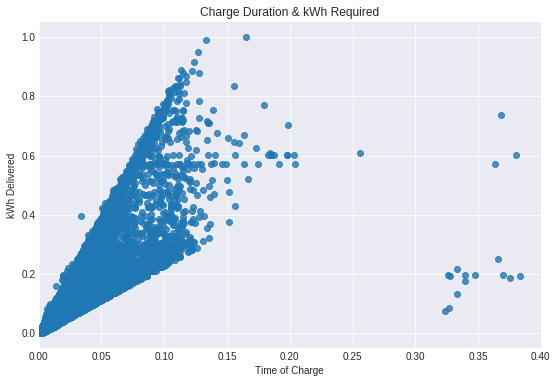

In [0]:
T=chargingdf["timeOfCharge"]
E=chargingdf["kWhDelivered"]

#Normalization
values = T.values
values = values.reshape((len(values), 1))

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

values2 = E.values
values2 = values2.reshape((len(values2), 1))

scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2 = scaler2.fit(values2)

# Normalize time of charge and kwh delivered
t = scaler.transform(values)
e = scaler2.transform(values2)

#Formatting for plotting
t=[i for sublist in t for i in sublist]
e=[i for sublist in e for i in sublist]

#Setting figure size
plt.rcParams['figure.figsize'] = (9, 6)

#Avoiding outliers values
plt.xlim(0, 0.4)

#Use the function regplot to make a scatterplot
sns.regplot(x=t, y=e, fit_reg = False)
plt.title("Charge Duration & kWh Required")
plt.xlabel("Duration of Charge")
plt.ylabel("kWh Required")
plt.show()




We clearly see a high correlation between the duration of charge and the kWh delivered. The few points on the right of the plot can indicate some cases of malfunction of the chargers.

**2) Analysis of time/energy during the peek/offpeek times**

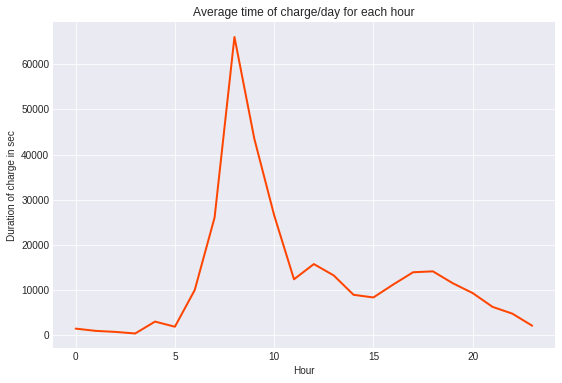

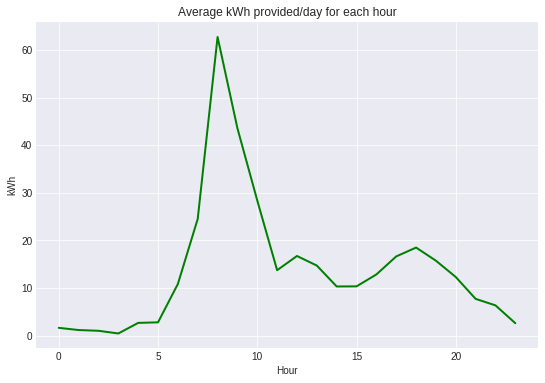

Average energy provided daily during the peek : 100.11 kWh
Average energy provided daily offpeek : 238.28 kWh


Average total daily cost : 38.23 $




In [0]:
total_charge_time =[0]*24
total_energy_consumed =[0]*24
hour_list=list(range(0,24))
nb_days=nb_weeks*7

#Calculating the average duration of charge and kwh requested per day for each hour 
for i in range(0,len(chargingdf.index)):
    total_charge_time[chargingdf.iloc[i,3]]+=chargingdf.iloc[i,2]/nb_days
    total_energy_consumed[chargingdf.iloc[i,3]]+=chargingdf.iloc[i,5]/nb_days

#Plotting
plt.plot( hour_list, total_charge_time,  marker='', color='orangered', linewidth=2)
plt.title("Average time of charge/day for each hour")
plt.xlabel("Hour")
plt.ylabel("Duration of charge in sec")
plt.show()

plt.plot( hour_list, total_energy_consumed, marker='', color='green', linewidth=2)
plt.title("Average kWh provided/day for each hour")
plt.xlabel("Hour")
plt.ylabel("kWh")
plt.show()

avg=0
avg_peek=0
avg_8_11_19_22=0
avg_0_7_23_00=0

#Average kWh provided
for i in range(24):
    avg+=total_energy_consumed[i]
    if (i>=12 and i<=18):
        avg_peek+=total_energy_consumed[i]
    elif (i>=19 and i<=22) or (i>=8 and i<=11):
        avg_8_11_19_22+=total_energy_consumed[i]

    elif (i>=0 and i<=7) or (i==23 or i==0):
        avg_0_7_23_00+=total_energy_consumed[i]

print("Average energy provided daily during the peek : %.2f kWh"%avg_peek)
print("Average energy provided daily offpeek : %.2f kWh\n\n"%(avg-avg_peek))

print("Average total daily cost : %.2f $\n\n"%(avg_peek*0.24+avg_8_11_19_22*0.067+avg_0_7_23_00*0.03))

Firstly, we can observe that the two plots confirm the strong correlation between the duration of charge and the kWh delivered. It also confirm the fact that the activity of the chargers is particularly strong between 7am and 10 am.

Secondly, we notice that on average, at the peek (8 am) the kWh delivered are slightly above 60. That represents approximately 18% of the total energy provided on average per day.

We finally find that the average energy provided daily between noon and 6pm is around 100.11 kWh, over a total of 338.39 kWh per day. So we have on average that **around 29.6 % of the total energy provided daily is provided at the peek time**. The average total daily cost of the energy provided (given the time-of-use rates) is 38.23$ 


# USER CLUSTERING

To cluster the users we'll :

1.   Remove the rows where there isn't any userInputs.

2.   Extract, clean and organize the data from the userInputs 

3.   Apply the K-Means algorithm with 2 clustering criteria : the **standard deviation of the hour of the start** (from modifiedAt), the **standard deviation of the hour of the end** (from departureTime).

4.   Apply the K-Means algorithm with 3 clustering criteria : the **standard deviation of the hour of the start** (from modifiedAt), **the standard deviation of the hour of the end** (from departureTime) and **the pearson coefficient between the duration and the kwh requested**.






**1) 2D USER CLUSTERING**










Loading...
Loading Successful


Text(0, 0.5, 'std end time')

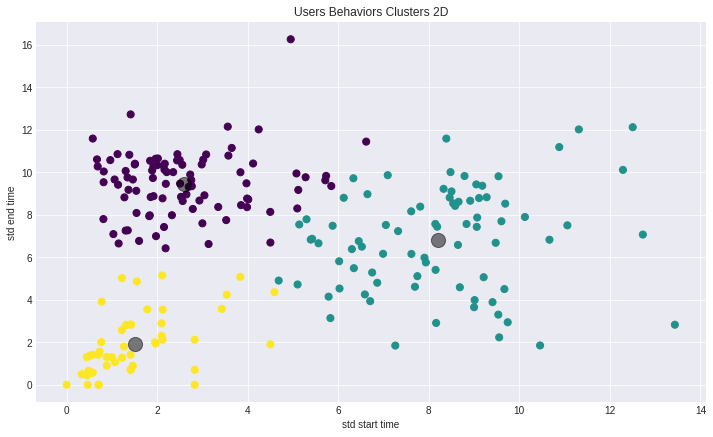

In [0]:
#Removing the rows where there is no user inputs
userdf = pd.DataFrame({"userInputs":df.userInputs}).dropna(subset=['userInputs'])

# Getting the values and plotting it TODO : modify timeOfUse and timeOfcharge

duration = []
kwhrequested = []
start= []
end= []
time_start = []
time_end = []
uid = []
uuid=[]

#Getting time of start(modifiedAt), time of departure(departureTime) and  khw requested (khwRequested) from the strings userInputs and saving it into the lists before clustering
def get_data_from_userInputs(fr,to):
    nb_space=0
    temp=""
    temp_convert = ""
    for j in range(fr,to) :
       for i in userdf['userInputs'].iloc[j] :
          #Update of the number of space
           if ((nb_space<3 or (nb_space>3 and nb_space<9) or (nb_space>=14 and nb_space<18) or (nb_space>=23 and nb_space <25)) and i==' ')  :
               nb_space+=1
       
           #Kwh Requested
           elif nb_space == 3 :
               if ((i.isnumeric() or i=='.' ) and (i!=',')):
                    temp+=i
               elif i==' ' :
                    temp_convert = float(temp)
                    temp=""
                    kwhrequested.append(temp_convert)
                    nb_space+=1

           #Start time
           elif nb_space >= 9 and nb_space <=13 :
               if i!="'" :
                   temp+=i
                   if i==' ' and nb_space<13 :
                       temp+=i
                       nb_space+=1
                   elif i==' ' and nb_space==13:
                       nb_space+=1  
                       temp_convert = datetime.datetime.strptime(temp, '%a, %d %b %Y %H:%M:%S ')
                       temp=""
                       start.append(temp_convert)

           #End time        
           elif nb_space >= 18 and nb_space <=22 :
                if i!="'" :
                   temp+=i
                   if i==' ' and nb_space<22 :
                        temp+=i
                        nb_space+=1
                   elif i==' ' and nb_space==22:
                        nb_space+=1  
                        temp_convert = datetime.datetime.strptime(temp, '%a, %d %b %Y %H:%M:%S ')
                        temp=""
                        end.append(temp_convert)
           #User ID              
           elif nb_space == 25  :
                if i.isnumeric() :
                    temp+=i
                else:
                    temp_convert = int(temp)
                    temp=""
                    uid.append(temp_convert)
                    nb_space=0
                    break
                    
                  
print("Loading...")         
                    
get_data_from_userInputs(0,len(userdf['userInputs']))

print("Loading Successful")

#Calculing time delta from start time to end time and add it to the list duration
for i in range(len(start)) :
    duration.append((end[i]-start[i]).total_seconds())   

#Getting the hour of start and the hour of end from the lists start and end
for i in range(len(start)) :
    time_start.append(start[i].hour)
    time_end.append(end[i].hour)

#Removing the doubles from the list of the usersID 
uuid = list(set(uid))

ts=[]
te=[]
dur=[]
kwh=[]
cor_dur_kwh =[]

TS=[]
TE=[]
DUR=[]
KWH=[]

#Creating 4 lists of lists for each user for each criterion
for i in range(len(uuid)) :
    for j in range(len(uid)) :
        if uid[j]==uuid[i] :
            ts.append(time_start[j])
            te.append(time_end[j])
            dur.append(duration[j])
            kwh.append(kwhrequested[j])

    TS.append(ts)
    TE.append(te)
    DUR.append(dur)
    KWH.append(kwh)
    ts=[]
    te=[]
    dur=[]
    kwh=[]


#Computing the standard deviation and setting up the inputs for the K mean algorithm in three lists
for i in range(len(TS)) :
    if (len(TS[i])>1):
          corr,_ = (scipy.stats.pearsonr(DUR[i], KWH[i]))
          #We remove the NaN and save the std_start, std_end and pearson coef 
          if (math.isnan(corr)==False):
              ts.append(statistics.stdev(TS[i]))
              te.append(statistics.stdev(TE[i]))
              corr,_ = (scipy.stats.pearsonr(DUR[i], KWH[i]))
              cor_dur_kwh.append(corr)



#Computing the algorithm using std_start/std_end and setting a 2D scatterplot
X = np.array(np.array(list(zip(ts, te))))

#Setting figure size
plt.rcParams['figure.figsize'] = (12, 7)

#Initializing KMeans
kmeans = KMeans(n_clusters=3)
#Fitting with inputs
kmeans.fit(X)
#Predicting the clusters
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title("Users Behaviors Clusters 2D")
plt.xlabel("std start time")
plt.ylabel("std end time")

There are three clusters. 

Cluster One : It represents a group of users that have a predictable behavior. They use the chargers most of the time at the same time and their time of use is approximately the same each time.

Cluster Two : It represents a group of users that are much less predictable. They don't use the service at the same time and their time of use is not always the same.

Cluster Three : This group of users usually starts to use the service around the same time, but the duration of the use is less predictable.


**3D USER CLUSTERING**


Text(0.5, 0.92, 'Users Behaviors Clusters 3D')

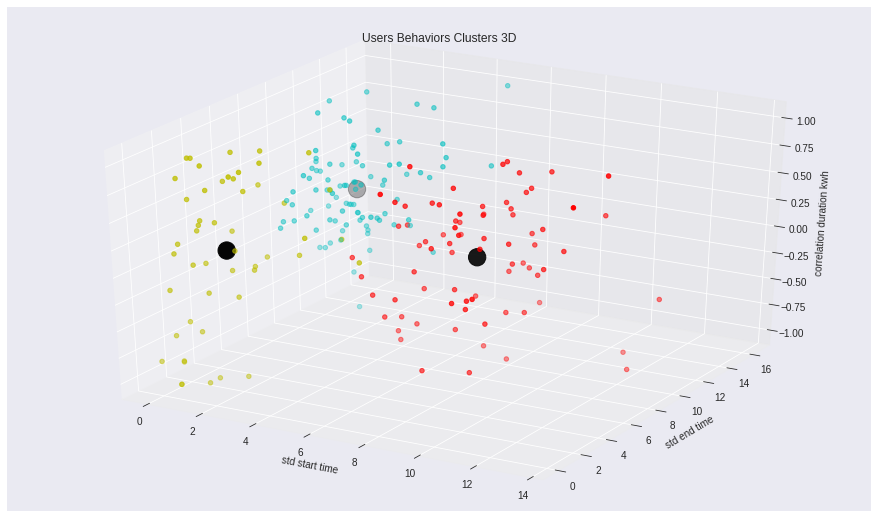

<Figure size 864x504 with 0 Axes>

In [0]:
#Computing the algorithm using std_start/std_end/correlation_duration_kwh and setting a 2D scatterplot
X=np.asarray(list(zip(ts,te,cor_dur_kwh)))

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

#Initializing KMeans
kmeans = KMeans(n_clusters=3)
#Fitting with inputs
kmeans = kmeans.fit(X)
#Predicting the clusters
labels = kmeans.predict(X)
#Getting the cluster centers
C = kmeans.cluster_centers_

#Setting colors of the clusers
label=np.array(labels)
colormap = np.array(['r', 'y', 'c'])


ig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colormap[labels])
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='o', c='#050505', s=300)
ax.set_xlabel('std start time')
ax.set_ylabel('std end time')
ax.set_zlabel('correlation duration kwh')
ax.set_title('Users Behaviors Clusters 3D')